In [1]:
import gcsfs 
import intake
import xarray as xr

In [2]:
#Função para acertar a variável tempo! Pois alguns formatos disponiveis no CMIP6 para a variável time dificultam sua manipulação. 
import cftime

def to_360day_monthly(da):
    ''' Conversão da dimensão de tempo de modelos climáticos.
        Função criada por Claire Carouge no CLEX CMS Blog'''
    val = da.copy()
    time1 = da.time.copy()
    for itime in range(val.sizes['time']):
        bb = val.time.values[itime].timetuple()
        time1.values[itime] = cftime.Datetime360Day(bb[0],bb[1],16)
    val = val.assign_coords({'time':time1})
    return val

In [11]:
#Acessa o conjunto de metadados do CMIP6 hospedados no Google Cloud.
cmip6 = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [12]:
#Pesquisa para o IPSL Sea Surface Temperature e Salinidade, Frequência Mensal, Série histórica, gride_label>gn
pesquisa = dict(source_id = 'IPSL-CM6A-LR',
                table_id = 'Omon',
                variable_id = ['thetao', 'so'],
                experiment_id=['historical'],
                member_id = 'r1i1p1f1')

In [13]:
#Realiza a pesquisa
cmip6_ipsl = cmip6.search(require_all_on=['source_id'], **pesquisa) 

/home/gabriel/anaconda3/envs/myenv/lib/python3.11/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


In [14]:
cmip6_ipsl_dsets = cmip6_ipsl.to_dataset_dict(aggregate=True,
                                           storage_options={'token': 'anon'},
                                           zarr_kwargs={'consolidated': True,
                                                        'decode_times': True,
                                                        'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/tmp/ipykernel_5011/2406752552.py:1: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  cmip6_ipsl_dsets = cmip6_ipsl.to_dataset_dict(aggregate=True,


In [15]:
#Comando usado para exibir as chaves dos conjuntos de dados que foram baixados
#O primeiro é a chave associado aos dados historicos e a segunda é a chave associado aos dados do cenário ssp585
cmip6_ipsl_dsets.keys() 

dict_keys(['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn'])

In [16]:
#Define uma variável para receber esses dados
ds = cmip6_ipsl_dsets['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn'].squeeze() #Retorna os dados associados a chave que definimos.

In [17]:
#Corrigindo os times. Utiliza a função definida anteriormente para correção da variável time
ds = to_360day_monthly(ds)

In [18]:
#Deleta as variáveis presentes no xarray que não são do nosso interesse.
ds = ds.drop(["bounds_nav_lat", "bounds_nav_lon", "olevel_bounds", "time_bounds", "member_id", "dcpp_init_year"])

In [19]:
#Seleciona a região de interesse para nossas análises.
ds = ds.isel(x=slice(220,305),y=slice(30,235))

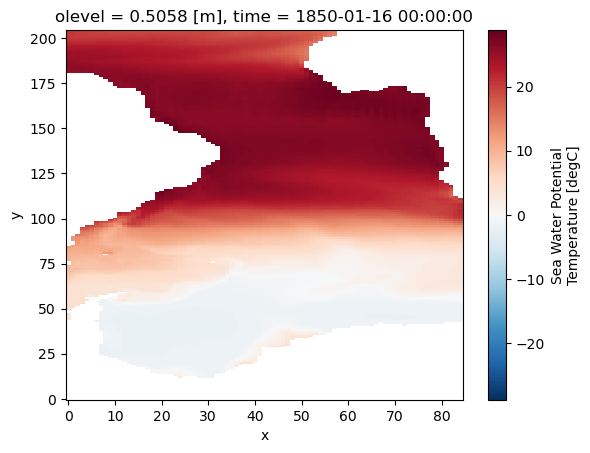

In [20]:
ds.isel(time=0, olevel=0).thetao.plot()

In [21]:
#Seleciona um time range de 1950 a 1970
ds_time = ds.sel(time=slice("1950", "1970"))

In [22]:
ds_time

<xarray.Dataset>
Dimensions:  (y: 205, x: 85, olevel: 75, time: 252)
Coordinates:
    area     (y, x) float32 dask.array<chunksize=(205, 85), meta=np.ndarray>
    nav_lat  (y, x) float32 dask.array<chunksize=(205, 85), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(205, 85), meta=np.ndarray>
  * olevel   (olevel) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time     (time) object 1950-01-16 00:00:00 ... 1970-12-16 00:00:00
Dimensions without coordinates: y, x
Data variables:
    so       (time, olevel, y, x) float32 dask.array<chunksize=(5, 75, 205, 85), meta=np.ndarray>
    thetao   (time, olevel, y, x) float32 dask.array<chunksize=(4, 75, 205, 85), meta=np.ndarray>
Attributes: (12/58)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn

In [23]:
#Abre minha área de estudo como um arquivo kml com o geopandas
import geopandas as gpd
import fiona 

fiona.drvsupport.supported_drivers['KML'] = 'rw'

df = gpd.read_file('areaprojeto (3).kml', driver="KML")

In [24]:
#Transforma meu arquivo em um shapefile
df.to_file('areaprojeto.shp', driver='ESRI Shapefile')

/tmp/ipykernel_5011/4075887656.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('areaprojeto.shp', driver='ESRI Shapefile')


In [25]:
#Abre o arquivo em shapefile
df = gpd.read_file('area_de_estudo.shp', driver="ESRI Shapefile")

In [26]:
import xarray as xr
import geopandas as gpd
import regionmask

#Lê o dataset
ds = ds_time

#Lê o poligono no geopandas como um GeoDataFrame
gdf = gpd.read_file('area_de_estudo.shp',  driver="ESRI Shapefile")

#Converte o GeoDataFrame para um objeto region mask
mask = regionmask.mask_geopandas(gdf, ds.coords, lon_name='nav_lon', lat_name='nav_lat')

#Aplica a máscara ao dataset
masked_data = ds.where(mask==mask, drop=True)



In [ ]:
dataframe = masked_data.to_dataframe().dropna()